In [184]:
# Import machine learning and dataset modules
%matplotlib inline
import torch
import tarfile
import os

import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# Enable PyTorch to use CUDA cores if they are avialable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
batch_size = 4

In [40]:
# Implement custom dataset loader for synthetic data
class SyntheticDataset(Dataset):
    def __init__(self, tar_path='datasets/synthetic-19:04:19.tar.gz', transform=None):
        self.X = []
        self.y = []
        self.transform = transform
        
        with tarfile.open(tar_path) as tar:
            for member in tar.getmembers():
                if member.isfile():
                    f = tar.extractfile(member)
                    fn = member.name
                    bn = os.path.basename(fn)
                    uuid = os.path.basename(Path(fn).parent.parent) + os.path.basename(Path(fn).parent)
                    df = pd.read_csv(f)
                    
                    # If filename is features.csv, append to y tensor
                    if 'features.csv' in bn:
                        df['network_name'] = [os.path.splitext(name)[0] for name in df['network_name']]
                        df.drop(['population', 'backend'], axis=1, inplace=True)
                        self.y.append(df)
                        
                    # If filename is timeseries.csv, append to X tensor
                    if 'timeseries.csv' in bn:
                        df['uuid'] = uuid
                        self.X.append(df)
        
        self.y = pd.concat(self.y)
        self.X = pd.concat(self.X)
        
        self.network_mapping = {k: v for v, k in enumerate(self.y['network_name'].unique())}
        self.y['network_type'] = self.y['network_name'].map(self.network_mapping)
        
        self.y_data = self.y.drop(['network_name'], axis=1).to_numpy(dtype=np.float64)
        
        # Stackoverflow magic
        g = self.X.groupby('uuid').cumcount()
        self.X_data = (self.X.set_index(['uuid', g])
            .unstack(fill_value=-1).stack()
            .groupby(level=0)
            .apply(lambda x: x.values.tolist())
            .tolist())
        
        self.X_data = np.array(self.X_data, dtype=np.int)
    
    def __getitem__(self, index):
        inputs, targets = self.X_data[index], self.y_data[index]
        s = inputs[0].sum()
        inputs = np.divide(inputs, s)
        inputs[inputs < 0] = -1
        
        sample = torch.from_numpy(inputs), torch.from_numpy(targets)
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        
    def __len__(self):
        return len(self.y)

In [122]:
def plot_synthetic(ts):
    ts = pd.DataFrame(ts[~np.all(ts == -1, axis=1)],
                      columns=['susceptible', 'infected', 'recovered', 'dead'])
    ts = pd.DataFrame(ts, columns=['susceptible', 'infected', 'recovered', 'dead'])
    ts.plot()
    plt.xlabel('days')
    plt.ylabel('fraction')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

In [267]:
def plot_historical(title, ts, to_file=False):
    ts = pd.DataFrame(ts[~np.all(ts == -1, axis=1)],
                      columns=['infected', 'dead'])
    ts = pd.DataFrame(ts, columns=['infected', 'dead'])
    # Set plot name to county name
    ax= ts.plot()
    fig = ax.get_figure()
    t= plt.title(title)
    x= plt.xlabel('days')
    y= plt.ylabel('individuals')
    
    if to_file:
        plt.savefig(title)
    
    plt.close(fig)
    plt.clf()
    plt.cla()
    
    if not to_file:
        plt.show()

In [142]:
# Split up training, validation, and testing dataset
whole_set = SyntheticDataset()

l = len(whole_set)

# training = 50%, validation = 20%, testing = 30%
n_val = int(0.2*l)
n_test = int(0.3*l)
n_train = l - n_test - n_val

train_set, val_set, test_set = random_split(whole_set, [n_train, n_val, n_test])

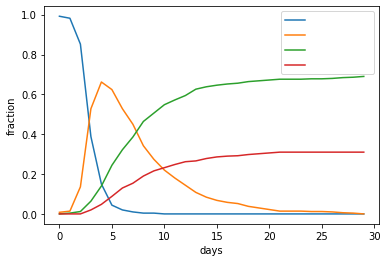

(initial_infected           10
 network_name        BA-4-4000
 infectiousness       0.106163
 i_out                0.709634
 i_rec_prop           0.916985
 Name: 0, dtype: object,
 (501, 4))

In [143]:
# Dataset number
DSN = 232

# Plot data for sanity
plot_synthetic(whole_set[DSN][0].numpy())

# Print out parameters
ts = whole_set[DSN][0].numpy()
whole_set.y.iloc[DSN, :-1], whole_set.X_data.shape[1:]

In [144]:
class HistoricalDataset(Dataset):
    def __init__(self, data_path='datasets/nyt.csv', transform=None):
        self.transform = transform
        self.X = dict()
        self.X_data = []
        
        with open(data_path) as f:
            df = pd.read_csv(f)
            self.X = list(d[1] for d in df.groupby('county'))
        
        self.X_data = [None]*len(self.X)
        
        for i, v in enumerate(self.X):
            self.X_data[i] = self.X[i].loc[:, 'cases':'deaths'].to_numpy()
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, index):
        return self.X_data[index]
        

In [145]:
historical_set = HistoricalDataset()

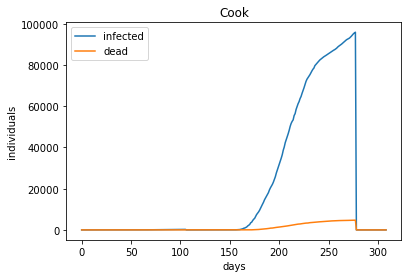

(           fips        date      state county  cases  deaths
 46193   13075.0  2020-03-30    Georgia   Cook      1       0
 46194   13075.0  2020-03-31    Georgia   Cook      1       0
 46195   13075.0  2020-04-01    Georgia   Cook      1       0
 46196   13075.0  2020-04-02    Georgia   Cook      1       0
 46197   13075.0  2020-04-03    Georgia   Cook      1       0
 ...         ...         ...        ...    ...    ...     ...
 140578  27031.0  2020-07-09  Minnesota   Cook      1       0
 140579  27031.0  2020-07-10  Minnesota   Cook      1       0
 140580  27031.0  2020-07-11  Minnesota   Cook      1       0
 140581  27031.0  2020-07-12  Minnesota   Cook      1       0
 140582  27031.0  2020-07-13  Minnesota   Cook      1       0
 
 [309 rows x 6 columns],
 1894)

In [254]:
# Dataset information
DSN = 411
# LA = 1018
# COOK = 411

# Plot historical data
plot_historical(historical_set.X[DSN]['county'].iloc[0], historical_set[DSN])

# Print county data
historical_set.X[DSN], len(historical_set)

In [268]:
%matplotlib auto
def save_historical(historical_set):
    # Turn interactive plotting off
    plt.ioff()
    if not os.path.exists('datasets/county_plots'):
        os.makedirs('datasets/county_plots/')
    
    for i in range(len(historical_set)):
        e = historical_set[i]
        n = historical_set.X[i]['county'].iloc[0]
        plot_historical(f'datasets/county_plots/{n}.png', e, to_file=True)
    
    plt.ion()

save_historical(historical_set)
%matplotlib inline

Using matplotlib backend: Qt5Agg
